In [1]:
onColab = False

if onColab:
    ! pip install kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

In [2]:
if onColab:
    ! kaggle datasets download raddar/chest-xrays-indiana-university

In [3]:
import zipfile
import os

if onColab:
    file_name = "chest-xrays-indiana-university.zip"
    
    # extract the file from the zip
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall("chest_xrays_data")

In [4]:
if onColab:
    !ls chest_xrays_data

In [5]:
if onColab: 
    img_dir = 'chest_xrays_data/images/images_normalized/'
    reports_dir = 'chest_xrays_data/indiana_reports.csv'
    projections_dir = 'chest_xrays_data/indiana_projections.csv'
else:
    img_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
    reports_dir = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
    projections_dir = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import BioGptTokenizer, BioGptModel

from tqdm import tqdm
from tqdm.auto import trange

import torchvision
from torchvision import transforms as T

In [9]:
# for BioGPT tokenizer
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.2 MB/s eta 0:00:00a 0:00:01


In [10]:
torch.backends.cudnn.benchmark = True

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using device: {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "Using CPU")

Using device: Tesla T4


#### **Preprocessing**

In [11]:
reports_df = pd.read_csv(reports_dir)
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [12]:
projections_df = pd.read_csv(projections_dir)
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [13]:
# filter the rows with null findings
reports_filtered = reports_df.dropna(subset=["findings"])

# keep only entries in projections that have a filtered report associated (association through uid)
projections_filtered = projections_df[projections_df["uid"].isin(reports_filtered["uid"])]
reports_filtered.shape, projections_filtered.shape

((3337, 8), (6469, 3))

In [14]:
VAL_SIZE = 0.1

uids = reports_filtered.uid.unique()

train_ds, val_ds = train_test_split(
    uids,
    test_size=VAL_SIZE,
    random_state=42
)

len(train_ds), len(val_ds)

(3003, 334)

In [15]:
# adjusted dataset
class ChestXRayDataset(Dataset):
    def __init__(self, reports_df, projections_df, image_folder, tokenizer, uids, transforms):
        self.reports_df = reports_df[reports_df["uid"].isin(uids)].reset_index(drop=True)
        self.projections_df = projections_df
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        # a series of transformations to be applied to images before feeding them into a model
        self.transform = transforms

    def __len__(self):
        return len(self.reports_df)

    def __getitem__(self, idx):
        row = self.reports_df.iloc[idx]
        uid = row["uid"]
        text = row["findings"]

        # tokenize findings column
        encoded_text = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=144,
            return_tensors="pt"
        )

        # find the path and filename of the associated image
        image_filename = self.projections_df[self.projections_df["uid"] == uid]["filename"].values[0]
        image_path = f"{self.image_folder}/{image_filename}"

        # load and trasform the image
        image = Image.open(image_path).convert("L")  # conversion to grayscale
        image = self.transform(image)

        # return the image, label (finding)
        return image, encoded_text["input_ids"].squeeze(0), encoded_text["attention_mask"].squeeze(0)

tf = T.Compose([
    T.Resize((224, 224)),  # resizing for pre-trained models
    T.ToTensor(),
])

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")
tokenizer.pad_token = tokenizer.eos_token

train_dataset = ChestXRayDataset(reports_filtered, projections_filtered, img_dir, tokenizer, train_ds, tf)
val_dataset = ChestXRayDataset(reports_filtered, projections_filtered, img_dir, tokenizer, val_ds, tf)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [16]:
BATCH_SIZE = 32

# create the DataLoader to generate batches of the dataset and iterate over them
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

In [17]:
def conv_layer(n_input, n_output, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(n_input, n_output, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(n_output),
        nn.MaxPool2d(2)
    )

In [18]:
encoder = nn.Sequential(
            conv_layer(1, 64, 3),
            conv_layer(64, 128, 3),
            conv_layer(128, 256, 3),
            conv_layer(256, 512, 3)
        )

encoder.load_state_dict(torch.load("/kaggle/input/encodercnn/pytorch/default/1/encoder.pth"))
encoder.to(device)

<ipython-input-18-3b924056fbb6>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("/kaggle/input/encodercnn/pytorch/default/1/encoder.pth")

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

#### **Visualize the latent space generated**

In [19]:
data_iter = iter(val_loader)
inputs, _, _ = next(data_iter)

inputs = inputs.to(device)

with torch.no_grad():
    latent_space = encoder(inputs)

inputs = inputs.cpu().numpy()
latent_space = latent_space.cpu().numpy()

for idx in range(2):
    reconstructed = latent_space[idx, 0]

    print(f"{idx+1}) Latent Space (dim={len(latent_space[idx, 0])}) -> {reconstructed}")

1) Latent Space (dim=12) -> [[ 2.5508828   7.2977486   5.969074    4.796006   -0.2159234  -0.2159234
  -0.2159234  -0.2159234  -0.2159234   2.8532014   6.7296014   7.6166844 ]
 [ 3.8179643   2.6701677   2.3270016   1.1827587  -0.2159234  -0.2159234
  -0.2159234   0.63077176 -0.2159234  -0.2159234   0.16937844  5.06471   ]
 [ 0.64807343 -0.19872625 -0.03239683 -0.2159234  -0.2159234  -0.2159234
   3.0497649   0.18837212 -0.2159234  -0.2159234   1.9182886   1.999537  ]
 [-0.2159234  -0.2159234   0.15526113  2.2795231  -0.2159234   0.32185185
   0.8104213   0.09022417 -0.2159234  -0.2159234   0.38793865  0.89932513]
 [-0.2159234  -0.2159234   0.76517624 -0.2159234  -0.2159234   1.5289363
   4.066567    1.9766818  -0.2159234  -0.2159234   0.39696875  0.0379662 ]
 [-0.2159234   1.331047    0.45643103  2.1597247  -0.2159234   2.5458977
   2.8805177   0.9558277   0.59708804 -0.2159234  -0.2159234  -0.2159234 ]
 [-0.2159234  -0.2159234   0.49626178  4.5828576  -0.17339556  0.6019527
   1.12722

In [20]:
# uso BioGptModel invece di BioGptForCausalLM, perchè il primo è più adatto per generare embedding,
# mentre il secondo è utile per text generation
# transformerModel = BioGptModel.from_pretrained("microsoft/biogpt") 
transformerModel = GPT2LMHeadModel.from_pretrained("gpt2")

#for param in transformerModel.parameters():
#    param.requires_grad = False  # Freezes all transformer parameters

transformerModel.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [21]:
transformer_parameters= sum(p.numel() for p in transformerModel.parameters())
print(f"number of transformer parameters: {transformer_parameters}")

number of transformer parameters: 124439808


In [22]:
def linear_layer(dim_input, dim_output, drop_p=0.2, last=False):
    layers = [nn.Linear(dim_input, dim_output)]
    if not last:
        layers.append(nn.GELU())
        layers.append(nn.Dropout(p=drop_p))
    return nn.Sequential(*layers)

In [34]:
class FF_mapper(nn.Module):

    def __init__(self, dim_input, dim_output):
        super().__init__()
        self.ff = nn.Sequential(
            linear_layer(dim_input, 768),
            linear_layer(768, 896),
            #linear_layer(1024, 896),
            linear_layer(896, dim_output, last=True),
            nn.LayerNorm(dim_output)
        )
        

    def forward(self, latent_space):
        # flatter, permute and stuff
        batch_size, C, H, W = latent_space.shape
        latent_space = latent_space.permute(0, 2, 3, 1)  # (1, 12, 12, 512)
        latent_space = latent_space.view(batch_size, H * W, C)  # (1, 144, 512)
        return self.ff(latent_space)

In [35]:
def train(train_x, val_x, model, epochs=10):
    criterion = cross_entropy_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_x, criterion, optimizer)
            val_loss = eval_epoch(model, val_x, criterion)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

def cross_entropy_loss(pred_logits, true_tokens):
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)  # Ignore padding tokens
    pred_logits = pred_logits.view(-1, pred_logits.shape[-1])  # Flatten for loss computation
    true_tokens = true_tokens.view(-1)  # Flatten ground truth tokens
    return loss_fn(pred_logits, true_tokens)

def fit_epoch(model, train_x, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0

    # for epoch progress
    old_progress = -0.1
    new_progress = 0

    for idx, (images, text, attention) in enumerate(train_x):

        new_progress = idx/len(train_x)
        if (new_progress-old_progress >= 0.1):
            print(f"Epoch progress: {new_progress*100}%")
            old_progress = new_progress

        images = images.to(device)
        text = text.to(device)
        attention = attention.to(device)

        optimizer.zero_grad()

        # Get latent space representation
        with torch.no_grad():
            latent_space = encoder(images).to(device)

        # FFNN generates transformer input embeddings
        pred_embeds = model(latent_space)

        # len(pred_embeds), out => 32
        # len(pred_embeds[0]), out => 144
        # len(pred_embeds[0][0]), out => 768
        # pred_embeds.shape, out => [32, 144, 768] => [batch_size, text_dim, emb_dim]
        
        # generating the logits
        generated_logits = transformerModel(
            inputs_embeds=pred_embeds,
            attention_mask=attention,
            return_dict=True
        ).logits

        # Compute loss
        loss = criterion(generated_logits, text)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
        
    return running_loss / processed_data

def eval_epoch(model, val_x, criterion):
    running_loss = 0.0
    processed_data = 0
    model.eval()

    with torch.no_grad():
        for images, text, attention in val_x:
            
            images = images.to(device)
            text = text.to(device)
            attention = attention.to(device)

            # using imported models to create the data we need
            latent_space = encoder(images).to(device)

            pred_embeds = model(latent_space)

            # generating the logits
            generated_text = transformerModel(
                inputs_embeds=pred_embeds,
                attention_mask=attention,
                return_dict=True
            ).logits
    
            # Compute loss
            loss = criterion(generated_text, text)
            
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    return running_loss / processed_data

In [36]:
mapper = FF_mapper(512, 768).to(device)    # using GPT
# mapper = FF_mapper(512, 1024).to(device)    # using BioGPT

mapper_parameters= sum(p.numel() for p in mapper.parameters())
print(f"number of mapper parameters: {mapper_parameters}")

number of mapper parameters: 1773440


In [37]:
import time

start = time.time()
history = train(train_loader, val_loader, mapper, epochs=20)
print(f"Training duration: {(time.time() - start) / 60} (min)")

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:   5%|▌         | 1/20 [02:06<40:02, 126.44s/it]

loss:  7.021915100990458

Epoch 001 train_loss: 7.0219 val_loss: 6.5689
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  10%|█         | 2/20 [04:13<37:57, 126.55s/it]

loss:  6.395506914625776

Epoch 002 train_loss: 6.3955 val_loss: 6.3638
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  15%|█▌        | 3/20 [06:19<35:51, 126.55s/it]

loss:  6.31012704524588

Epoch 003 train_loss: 6.3101 val_loss: 6.3542
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  20%|██        | 4/20 [08:26<33:44, 126.54s/it]

loss:  6.24899357937752

Epoch 004 train_loss: 6.2490 val_loss: 6.2853
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  25%|██▌       | 5/20 [10:33<31:40, 126.72s/it]

loss:  6.197532060298514

Epoch 005 train_loss: 6.1975 val_loss: 6.2456
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  30%|███       | 6/20 [12:40<29:37, 126.95s/it]

loss:  6.127161386165213

Epoch 006 train_loss: 6.1272 val_loss: 6.1546
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  35%|███▌      | 7/20 [14:47<27:31, 127.06s/it]

loss:  6.0547011760955165

Epoch 007 train_loss: 6.0547 val_loss: 6.1103
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  40%|████      | 8/20 [16:55<25:25, 127.14s/it]

loss:  6.001817099591519

Epoch 008 train_loss: 6.0018 val_loss: 6.0642
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  45%|████▌     | 9/20 [19:02<23:19, 127.26s/it]

loss:  5.962564793038876

Epoch 009 train_loss: 5.9626 val_loss: 6.0011
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  50%|█████     | 10/20 [21:09<21:12, 127.22s/it]

loss:  5.911883425205312

Epoch 010 train_loss: 5.9119 val_loss: 5.9730
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  55%|█████▌    | 11/20 [23:16<19:04, 127.16s/it]

loss:  5.874127489455203

Epoch 011 train_loss: 5.8741 val_loss: 5.9472
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  60%|██████    | 12/20 [25:23<16:57, 127.13s/it]

loss:  5.840527483757506

Epoch 012 train_loss: 5.8405 val_loss: 5.9275
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  65%|██████▌   | 13/20 [27:31<14:49, 127.13s/it]

loss:  5.817813300071879

Epoch 013 train_loss: 5.8178 val_loss: 5.9011
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  70%|███████   | 14/20 [29:38<12:43, 127.20s/it]

loss:  5.792711384752963

Epoch 014 train_loss: 5.7927 val_loss: 5.8686
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  75%|███████▌  | 15/20 [31:45<10:36, 127.22s/it]

loss:  5.765084307244483

Epoch 015 train_loss: 5.7651 val_loss: 5.8669
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  80%|████████  | 16/20 [33:52<08:28, 127.22s/it]

loss:  5.737711429595947

Epoch 016 train_loss: 5.7377 val_loss: 5.8340
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  85%|████████▌ | 17/20 [36:00<06:21, 127.20s/it]

loss:  5.717359801556202

Epoch 017 train_loss: 5.7174 val_loss: 5.8307
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  90%|█████████ | 18/20 [38:07<04:14, 127.28s/it]

loss:  5.6935502468271455

Epoch 018 train_loss: 5.6936 val_loss: 5.7979
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  95%|█████████▌| 19/20 [40:15<02:07, 127.46s/it]

loss:  5.664604329048319

Epoch 019 train_loss: 5.6646 val_loss: 5.7935
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch: 100%|██████████| 20/20 [42:22<00:00, 127.15s/it]

loss:  5.641804324819686

Epoch 020 train_loss: 5.6418 val_loss: 5.7821
Training duration: 42.38235455751419 (min)


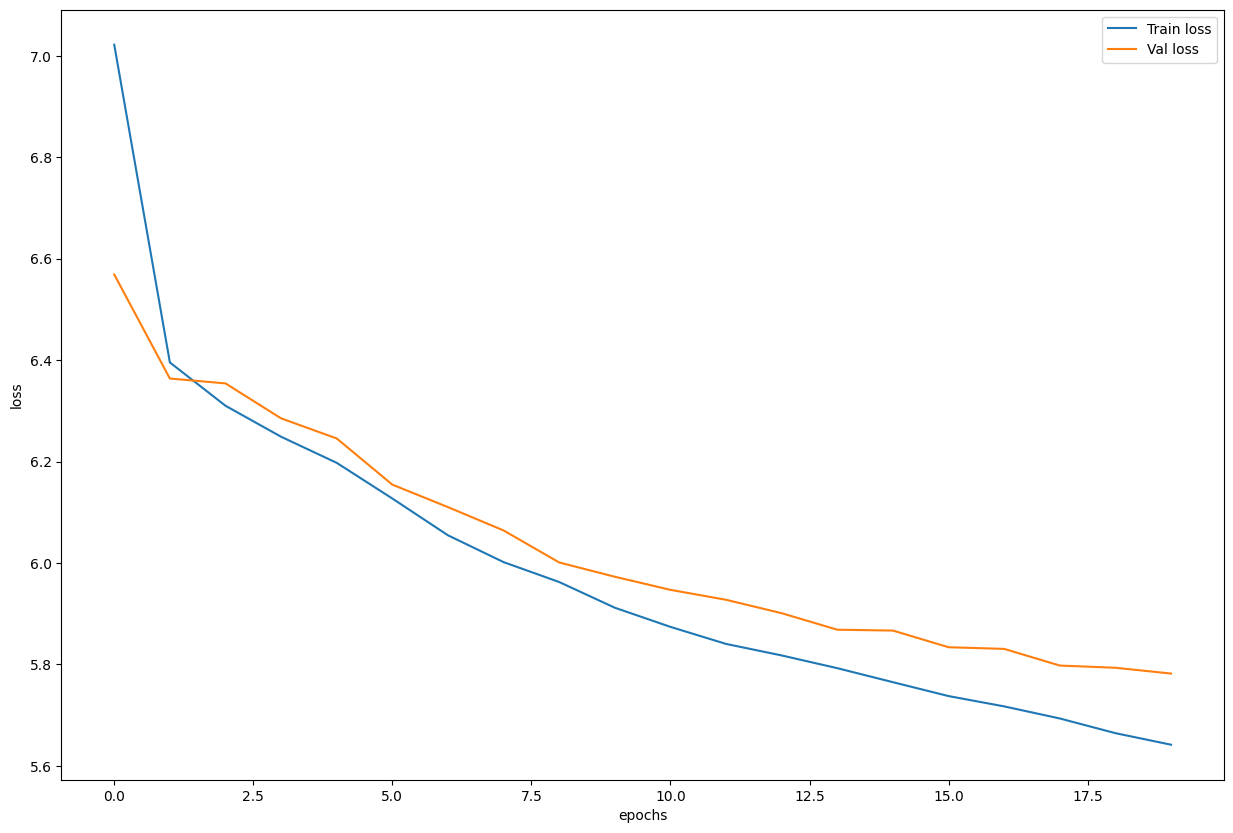

In [38]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

In [39]:
def generate_text(inputs_embeds, attention_mask):
    return transformerModel.generate(
        inputs_embeds=inputs_embeds, 
        max_length=288,
        attention_mask=attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=2,   # Evita ripetizioni
        top_k=50,   # Considera solo le 50 parole più probabili
        eos_token_id=None,
    )
    # return tokenizer.decode(generated_text[0], skip_special_tokens=True)
    # print("decoded generated text: ", decoded_text)

In [45]:
data_iter = iter(train_loader)
image, text, attention = next(data_iter)
image, text, attention = next(data_iter)

print(f"Real Text:\n{tokenizer.decode(text[0], skip_special_tokens=True)}\n\n")

image = image.to(device)
text = text.to(device)
attention = attention.to(device)

with torch.no_grad():
    latent_space = encoder(image).to(device)
    predicted_embedding = mapper(latent_space).to(device)    
    
    #embedding = transformerModel.embed_tokens(text).to(device)    # using BioGPT
    #embedding = transformerModel.transformer.wte(text).to(device)    # using GPT2


predicted_text = generate_text(predicted_embedding, attention)

print(f"Predicted Text:\n{tokenizer.decode(predicted_text[0], skip_special_tokens=True)}")

Real Text:
The heart is normal size. The mediastinum is unremarkable. There is no pleural effusion, pneumothorax, or focal airspace disease. There is stable mild XXXX deformity of the lower thoracic vertebral body.


Predicted Text:
.,, the,.. of the. the the of, of. is. and.-. (. or.:.
. a. in. The. to the

, is the is, and,
The other is a person's. I am not a not for the other one of a is not in a hospital. not an individual. an a a, a the person is an ordinary person who is in the hospital is no longer a patient is dead. This is one who are not yet dead is gone. A person with a heart. An individual is another.


A person in which the middle of which there is left the question of an emergency, an ambulance and


In [49]:
# torch.save(mapper.state_dict(), "ff_mapper_bioGPT.pth")    # using BioGPT
torch.save(mapper.state_dict(), "ff_mapper_GPT2.pth")    # using GPT2